# I am writing this to make a simple script that we a can use to take a look at this section of the data
# Currently this notebook was capably of running on my local machine with a total of only ~900 data points 


In [10]:
import torch 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import networkx as nx
import random
from p1data2pandas import load_data_frame_from_file

In [11]:

# loads the data into a dataframe, currently the name and type columns are unassigned
file_name = '/Users/AlexeiLe/Documents/ai-sci-hackathon-2025/material_characterize_project/graph_data.json'
df = load_data_frame_from_file(file_name)

In [12]:
print(df) # just to see 

                                                 smile  \
0                                                 [Ag]   
1    C/C(=C\C(=O)C(F)(F)F)/O[Al](O/C(=C\C(=O)C(F)(F...   
2    C(=C(\O[Al](O/C(=C\C(=O)C(F)(F)F)/C(F)(F)F)O/C...   
3    C/C(=C/C(=O)C)/O[Al](O/C(=C\C(=O)C)/C)O/C(=C\C...   
4    CC(/C(=C/C(=O)C(C)(C)C)/O[Al](O/C(=C\C(=O)C(C)...   
..                                                 ...   
856                           [O-2].[F-].[F-].[F-].[V]   
857                                               [Xe]   
858                                      O(OOOF)F.[Xe]   
859                                               [Zn]   
860                             C[CH2-].C[CH2-].[Zn+2]   

                                                 graph        name  \
0                                                  (0)  UNASSIGNED   
1    (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  UNASSIGNED   
2    (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  UNASSIGNED   
3    (0, 1, 2, 3, 4, 5,

In [13]:

index = 0

graph = df.at[index, 'graph']
smile = df.at[index, 'smile'] # apparently you should use at for single value access and loc for when you might grab others nearby 


In [14]:
# basic graph data generalization function, here we count the number of atoms in the molecule and store in a dictionary form
def get_atoms(g):
    res = {}

    for node, data in g.nodes(data=True): # loop through all of the nodes explicitly
        if (data['atom_type'] in res): res[data['atom_type']] += 1 # iterate dictionary vals
        else: res[data['atom_type']] = 1
    return res
        

atom_nums = get_atoms(graph)
print(atom_nums)

{'Ag': 1}


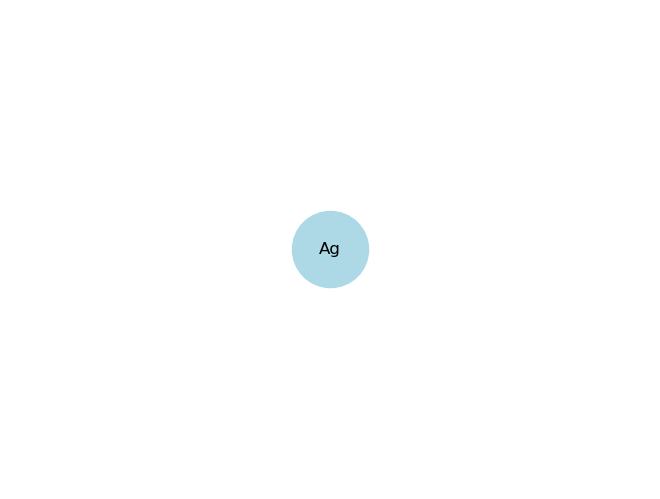

In [15]:
# turns out its not too hard to draw some smaller graphs for ease of visualization
import functools # for fun 
pos = nx.spring_layout(graph, seed=42) # basically tells it how it wants it to translate the graph into random 2d form 
# (bc remember it could be an arbitrary 3d mess of possibilities) Its fixed with a seed for ease of use rn
# NOTE THAT THIS ISNT PERFECT, IT WONT PRESERVE ISOMORPHISMS SO BE CAREFUL!!!

# i am predicting that as graphs get bigger were going to need a different node size parameter
size = functools.reduce(lambda x,y: x + y, atom_nums.values()) # this is a troll 

nx.draw(graph, pos, with_labels=False, node_color="lightblue", node_size = 1000 * (3/size)) # my size trick could tweak here
labels = {node: data['atom_type'] for node, data in graph.nodes(data=True)}

if (size < 10): font_size = 12
else: font_size = 6
nx.draw_networkx_labels(graph, pos, labels, font_size= font_size,  font_color='black')
plt.show()

In [16]:
# now lets calculate these values on our indexed graph first
import mendeleev # to get atomic weight stuff

# gonna make a quick dictionary which allows for fast lookup of values
mend_dict = dict() # KEY - element symbol: value - medeleev object

# Now lets think of some dataset exploration we could do to try and visualize the data we have

outside of the basic data that we have readily available, of which we currently have 
at a graph level: # of nodes, # of edges, edge/node info, 
at a  node level: 'atom_type', 'formal charge', 'orbitals'


it might be useful to consider the following: 
at a graph level: average node degree (could give more structural information), molecular weight(calculated from the atomic weight)
at a node level: access to atomic info (could be solved through a package), degree, # of valence electrons, partial charges, electronegativity (hybridization also but idk exactly what this is yet)
at an edge level: bond length somehow maybe??? (would help alot with the 3d geometry)

In [17]:

def get_atom_weight(s): 
    if s not in mend_dict: 
        mend_dict[s] = mendeleev.element(s)
    return mend_dict[s].atomic_weight

def calculate_molecular_weight(g): 
    return sum(list( get_atom_weight(data['atom_type']) for _, data in g.nodes(data=True)))

def calculate_average_degree(g):
    seen = set()
    node_to_degree = dict()
    for u,v in g.edges(): 
        if (u in seen and v in seen): 
            node_to_degree[u] += 1
            node_to_degree[v] += 1
        elif u in seen: 
            node_to_degree[u] += 1
            seen.add(v)
            node_to_degree[v] = 1
        elif v in seen: 
            node_to_degree[v] += 1
            seen.add(u)
            node_to_degree[u] = 1
        else: 
            seen.add(u)
            node_to_degree[u] = 1
            node_to_degree[v] = 1
    return sum(node_to_degree.values()) / max(len(node_to_degree),1) 

# maybe try implementing electronegativity (although it might be really hard im not sure lmk)

molecular_weight = calculate_molecular_weight(graph)
average_degree = calculate_average_degree(graph)

print(f"molecular weight: {molecular_weight} \naverage degree: {average_degree}")


molecular weight: 107.8682 
average degree: 0.0


In [ ]:
PAULING_EN_STATIC = {
    'H':   2.20,   # Hydrogen
    'He':  0.00,   # no defined EN, set to 0.0
    'Li':  0.98,
    'Be':  1.57,
    'B':   2.04,
    'C':   2.55,
    'N':   3.04,
    'O':   3.44,
    'F':   3.98,
    'Ne':  0.00,   # no defined EN, set to 0.0
    'Na':  0.93,
    'Mg':  1.31,
    'Al':  1.61,
    'Si':  1.90,
    'P':   2.19,
    'S':   2.58,
    'Cl':  3.16,
    'Ar':  0.00,   # no defined EN, set to 0.0
    'K':   0.82,
    'Ca':  1.00,
    'Sc':  1.36,
    'Ti':  1.54,
    'V':   1.63,
    'Cr':  1.66,
    'Mn':  1.55,
    'Fe':  1.83,
    'Co':  1.88,
    'Ni':  1.91,
    'Cu':  1.90,
    'Zn':  1.65,
    'Ga':  1.81,
    'Ge':  2.01,
    'As':  2.18,
    'Se':  2.55,
    'Br':  2.96,
    'Kr':  3.00,   # krypton has a small EN
    'Rb':  0.82,
    'Sr':  0.95,
    'Y':   1.22,
    'Zr':  1.33,
    'Nb':  1.60,
    'Mo':  2.16,
    'Tc':  1.90,
    'Ru':  2.20,
    'Rh':  2.28,
    'Pd':  2.20,
    'Ag':  1.93,
    'Cd':  1.69,
    'In':  1.78,
    'Sn':  1.96,
    'Sb':  2.05,
    'Te':  2.10,
    'I':   2.66,
    'Xe':  2.60,   # xenon has a reported EN
}


def get_atom_pauling_en(atom_sym: str) -> float:
    """
    1. Cache the mendeleev.Element in mend_dict.
    2. Try elem.electronegativity_pauling (might be a method).
    3. If missing/None, fall back to PAULING_EN_STATIC or 0.0.
    Always returns a float.
    """
    #gets the element
    if atom_sym not in mend_dict:
        mend_dict[atom_sym] = mendeleev.element(atom_sym)
    elem = mend_dict[atom_sym]

    # attempt to get the attribute is the value exists in mendeleev
    en_attr = getattr(elem, 'electronegativity_pauling', None)

    # it might be a method, so have to call it and extract the value
    if callable(en_attr):
        val = en_attr()
    else:
        val = en_attr

    # if we still have nothing, this means it doesnt exist in mendeleev so use use the static table
    if val is None or not isinstance(val, (int, float)):
        return PAULING_EN_STATIC.get(atom_sym, 0.0)

    return float(val)

# quick check of the electronegativity function
test_vals = [get_atom_pauling_en(data['atom_type']) 
             for _, data in df.loc[0,'graph'].nodes(data=True)]
print(test_vals, [type(x) for x in test_vals])

def calculate_electronegativity_stats(g: nx.Graph):
    """
    Returns (avg_en, min_en, max_en) over all nodes in graph g,
    looking up each node’s data['atom_type'] as the symbol.
    """
    # extract every node’s Pauling EN
    ens = [
        get_atom_pauling_en(data['atom_type'])
        for _, data in g.nodes(data=True)
    ]
    # guard against empty graphs
    if not ens:
        return 0.0, 0.0, 0.0
    return sum(ens)/len(ens), min(ens), max(ens)

df['avg_en'], df['min_en'], df['max_en'] = zip(*df['graph'].apply(calculate_electronegativity_stats))

# quick check
print(df[['smile','avg_en','min_en','max_en']].head())

[1.93] [<class 'float'>]
                                               smile    avg_en  min_en  max_en
0                                               [Ag]  1.930000    1.93    1.93
1  C/C(=C\C(=O)C(F)(F)F)/O[Al](O/C(=C\C(=O)C(F)(F...  3.107097    1.61    3.98
2  C(=C(\O[Al](O/C(=C\C(=O)C(F)(F)F)/C(F)(F)F)O/C...  3.303500    1.61    3.98
3  C/C(=C/C(=O)C)/O[Al](O/C(=C\C(=O)C)/C)O/C(=C\C...  2.750000    1.61    3.44
4  CC(/C(=C/C(=O)C(C)(C)C)/O[Al](O/C(=C\C(=O)C(C)...  2.660000    1.61    3.44


In [ ]:
# now lets add this to the dataframe (took me about 30 seconds to run for everything)
def add_weights_and_connectivity_to_df(g):
    w = calculate_molecular_weight(g)
    d = calculate_average_degree(g)
    l = len(g.nodes())

    return w, d, l

df['avg deg'], df['weight (calculated)'], df['num atoms'] = zip(*df['graph'].apply(add_weights_and_connectivity_to_df)) 



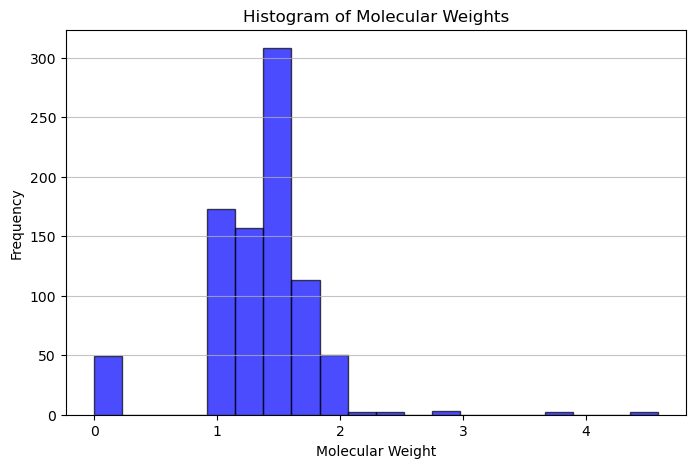

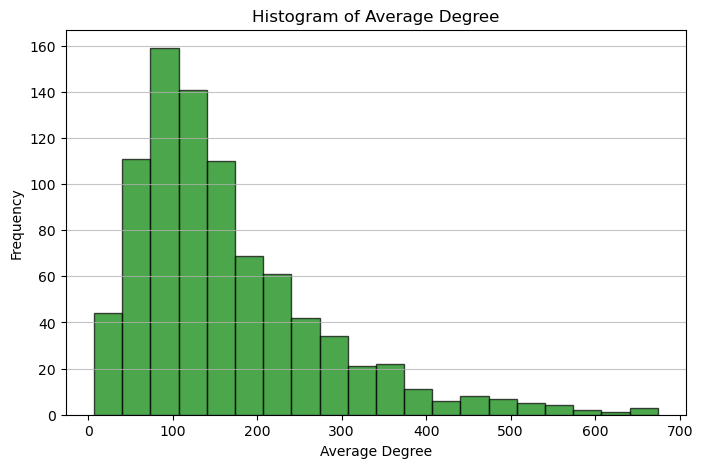

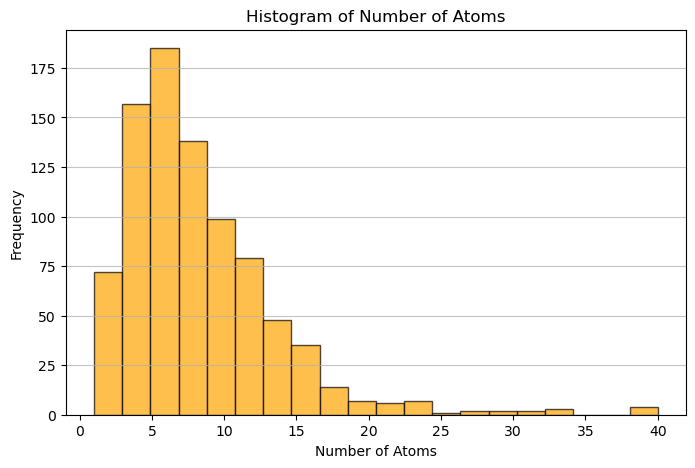

In [19]:
# now we take a look at these dataset histograms

# plot the weights of the dataset
plt.figure(figsize=(8, 5))
plt.hist(df['weight (calculated)'], bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of Molecular Weights')
plt.xlabel('Molecular Weight')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Plot histogram for average degrees
plt.figure(figsize=(8, 5))
plt.hist(df['avg deg'], bins=20, color='green', alpha=0.7, edgecolor='black')
plt.title('Histogram of Average Degree')
plt.xlabel('Average Degree')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Plot histogram for number of atoms
plt.figure(figsize=(8, 5))
plt.hist(df['num atoms'], bins=20, color='orange', alpha=0.7, edgecolor='black')
plt.title('Histogram of Number of Atoms')
plt.xlabel('Number of Atoms')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()